### Extra

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('data/HR_data.csv')

data = data.dropna()

#from column Round in features, leftstrip the string 'round_' and convert to int
data['Round'] = data['Round'].str.lstrip('round_').astype(int)
#same with column Phase, lefstrip 'phase' and convert to int
data['Phase'] = data['Phase'].str.lstrip('phase').astype(int)
print(data.head())

   Unnamed: 0  HR_TD_Mean  HR_TD_Median  HR_TD_std  HR_TD_Min  HR_TD_Max  \
0           0   78.663878         76.70   7.480043      67.25      92.48   
1           1   76.540732         76.61   2.584756      69.82      82.33   
2           2   78.173563         77.92   2.681255      72.22      82.80   
3           3   83.073688         83.88   7.363598      69.42      96.12   
4           4   72.281250         72.91   3.193762      64.95      79.98   

   HR_TD_AUC  HR_TD_Kurtosis  HR_TD_Skew  HR_TD_Slope_min  ...  upset  \
0  23048.450       -1.091448    0.369955          -0.7300  ...    1.0   
1  23959.920       -0.245338    0.338732          -0.3600  ...    2.0   
2  20324.605       -0.615922   -0.233047          -0.6300  ...    1.0   
3  24924.300       -0.866610   -0.046021          -0.4650  ...    1.0   
4  23052.100        0.200401   -0.560948          -0.3725  ...    3.0   

   hostile  alert  ashamed  inspired  nervous  attentive  afraid  active  \
0      1.0    2.0      1.0  

### Supervised model part

In [3]:
import warnings  # to silence convergence warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.neural_network import MLPRegressor

import sklearn as sk
from sklearn.decomposition import PCA, SparsePCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import (
    LinearRegression, LogisticRegression, LogisticRegressionCV,
    Ridge, Lasso, ElasticNet, Lars, LassoLars
)
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor
from sklearn.cross_decomposition import CCA
from sklearn.metrics import r2_score

from sklearn.decomposition import PCA, SparsePCA, FastICA, NMF, KernelPCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import BaseCrossValidator
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def load_data_cohort_based(data):
    # --- Custom CV Class ---
    class CohortCVSplitter:
        def __init__(self, cohort_array):
            self.cohort_array = np.array(cohort_array)
            self.unique_cohorts = np.unique(self.cohort_array)

        def split(self, X, y=None):
            for cohort in self.unique_cohorts:
                test_index = np.where(self.cohort_array == cohort)[0]
                train_index = np.where(self.cohort_array != cohort)[0]
                yield train_index, test_index

        def get_n_splits(self, X=None, y=None, groups=None):
            return len(self.unique_cohorts)

    # --- Preprocessing Function ---
    def preprocess_entire_X(X_full):
        X_full = X_full.drop(columns=['Individual', 'Cohort', 'Team_ID'], errors='ignore')
        X_full = X_full.drop(columns=['raw_data_path', 'original_ID'])

        print("Dropping individual and cohort columns")
        categorical_cols = ['Round', 'Phase', 'Puzzler']
        X_cat = X_full[categorical_cols].astype(str)
        X_num = X_full.drop(columns=categorical_cols, errors='ignore')
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        X_cat_encoded = encoder.fit_transform(X_cat)
        X_processed = np.hstack([X_num.values, X_cat_encoded])
        return X_processed, encoder


    ### Setup start
    
    data = data.dropna()
    data['Round'] = data['Round'].str.lstrip('round_').astype(int)
    data['Phase'] = data['Phase'].str.lstrip('phase').astype(int)


    emotion_columns = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed',
                    'inspired', 'nervous', 'attentive', 'afraid', 'active', 'determined']
    mapping = {
        'D1_1': 'group1',
        'D1_2': 'group2'
    }
    data_mod = data.copy()
    data_mod['Cohort'] = data['Cohort'].map(mapping).fillna('group3')
    Y_full_df = data_mod[emotion_columns]
    X_full_df = data_mod.drop(columns=emotion_columns)


    ### Setup end
    print("New cohort categories:", data['Cohort'].unique())

    # --- Build arrays for CV ---
    cohort_array = data_mod['Cohort'].values

    # --- Construct CV splitter ---
    CV = CohortCVSplitter(cohort_array=cohort_array)

    # --- Preprocess full X ---
    Xfull, encoder = preprocess_entire_X(X_full_df)
    Yfull = Y_full_df.values
    return CV, Xfull, Y_full_df, encoder, X_full_df, Yfull

data = pd.read_csv('data/HR_data_2.csv')
CV, Xfull, Y_full_df, encoder, X_full_df, Yfull = load_data_cohort_based(data)

New cohort categories: ['D1_4' 'D1_6' 'D1_1' 'D1_2' 'D1_3' 'D1_5']
Dropping individual and cohort columns


C:\Users\Bbjar\AppData\Local\Temp\ipykernel_26204\2954472435.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Round'] = data['Round'].str.lstrip('round_').astype(int)
C:\Users\Bbjar\AppData\Local\Temp\ipykernel_26204\2954472435.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Phase'] = data['Phase'].str.lstrip('phase').astype(int)


### data prep supervised model

In [6]:
helper = False 
if helper:
    # Define your Y columns as a list
    emotion_columns = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed',
                    'inspired', 'nervous', 'attentive', 'afraid', 'active', 'determined']


    # --- Prepare data ---
    Y = Y_full_df.copy()
    Y_std = StandardScaler().fit_transform(Y)
    Y_shifted = Y - Y.min().min()

    # --- Apply dimensionality reduction methods ---
    pca_full = PCA(n_components=5).fit(Y)
    pca = PCA(n_components=2).fit(Y)
    Y_pca = pca.transform(Y)

    spca_full = SparsePCA(n_components=5, alpha=1, random_state=0).fit(Y)
    spca = SparsePCA(n_components=2, alpha=1, random_state=0).fit(Y)
    Y_spca = spca.transform(Y)

    ica = FastICA(n_components=2, random_state=0)
    Y_ica = ica.fit_transform(Y)

    nmf = NMF(n_components=2, init='nndsvda', random_state=0)
    Y_nmf = nmf.fit_transform(Y_shifted)

    kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1)
    Y_kpca = kpca.fit_transform(Y_std)

    tsvd = TruncatedSVD(n_components=2, random_state=0)
    Y_tsvd = tsvd.fit_transform(Y_std)

    projection_dict = {
        'PCA': Y_pca,
        'Sparse PCA': Y_spca,
        'ICA': Y_ica,
        'NMF': Y_nmf,
        'Kernel PCA': Y_kpca,
        'Truncated SVD': Y_tsvd
    }

    # --- Compute reconstruction loss where possible ---
    Y_spca_reconstructed = np.dot(Y_spca, spca.components_)

    reconstruction_loss = {
        "PCA": mean_squared_error(Y, pca.inverse_transform(Y_pca)),
        "Sparse PCA": mean_squared_error(Y, Y_spca_reconstructed),
        "ICA": mean_squared_error(Y, ica.inverse_transform(Y_ica)),
        "NMF": mean_squared_error(Y_shifted, nmf.inverse_transform(Y_nmf)),
        "Kernel PCA": np.nan,
        "Truncated SVD": np.nan
    }

    # --- Main projection plots (without legend clutter) ---
    metadata_cols = ['Individual', 'Round', 'Phase', 'Cohort']
    fig, axs = plt.subplots(len(projection_dict), len(metadata_cols), figsize=(20, 28))
    axs = axs.reshape(len(projection_dict), len(metadata_cols))

    # Get random subset of 7 individuals for Individual plots
    unique_inds = X_full_df['Individual'].unique()
    subset_inds = np.random.choice(unique_inds, size=7, replace=False)

    for i, (name, proj) in enumerate(projection_dict.items()):
        for j, meta in enumerate(metadata_cols):
            data_mask = (X_full_df['Individual'].isin(subset_inds)) if meta == 'Individual' else np.ones(len(Y), dtype=bool)
            sns.scatterplot(
                x=proj[data_mask, 0], y=proj[data_mask, 1],
                hue=X_full_df.loc[data_mask, meta], ax=axs[i, j],
                palette='tab10', s=50, edgecolor='k', alpha=0.8, legend=False
            )
            axs[i, j].set_title(f"{name} colored by {meta}")
            axs[i, j].set_xlabel("Component 1")
            axs[i, j].set_ylabel("Component 2")

    plt.tight_layout()
    plt.show()

    # --- Legend-only plots ---
    for col in metadata_cols:
        plt.figure(figsize=(2, 2))
        ax = plt.gca()
        for val in X_full_df[col].unique():
            ax.scatter([], [], label=val)
        ax.legend(title=col, loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_axis_off()
        plt.title(f"Legend: {col}")
        plt.tight_layout()
        plt.show()

    # --- Variance explained for PCA and Sparse PCA ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, 6), pca_full.explained_variance_ratio_, color='skyblue')
    plt.title("PCA: Variance Explained")
    plt.xlabel("Component")
    plt.ylabel("Explained Variance Ratio")

    plt.subplot(1, 2, 2)
    spca_variance = np.var(spca_full.transform(Y), axis=0)
    spca_variance_ratio = spca_variance / np.sum(spca_variance)
    plt.bar(range(1, 6), spca_variance_ratio, color='salmon')
    plt.title("Sparse PCA: Approx. Variance Explained")
    plt.xlabel("Component")
    plt.ylabel("Relative Variance")

    plt.tight_layout()
    plt.show()

    # --- Output reconstruction losses ---
    reconstruction_df = pd.DataFrame.from_dict(reconstruction_loss, orient='index', columns=["Reconstruction MSE"])
    print(reconstruction_df.round(3))


In [7]:
helper = False
if helper:    
# Create a mask to hide the upper triangle
    def mask_upper_triangle(grid):
        for i, j in zip(*np.triu_indices_from(grid.axes, 1)):
            grid.axes[i, j].set_visible(False)

    # Use more distinctive color palette
    palette = sns.color_palette("husl", len(Y_full_df.columns))

    # Recreate the pairplot with the new palette
    pair_plot = sns.pairplot(Y_full_df, diag_kind="hist", 
                            plot_kws={"alpha": 0.7, "s": 20, "edgecolor": "black"},
                            palette=palette)

    # Mask the upper triangle
    mask_upper_triangle(pair_plot)

    # Add title and adjust layout
    pair_plot.fig.suptitle("Pairplot of Emotions (Lower Triangle Only)", y=1.02)
    plt.tight_layout()
    plt.show()




##### 1 Split dataset based on cohort value (merging all groups pertaining to cohort 3)
##### 2 Remove individual and cohort as features of X
##### 3 onehot encode categorical variables: This includes, round, phase and puzzler. 
##### 4 Choose the column that we will predict of Y (for the "other supervised models"). CCA predicts all emotions. 

### CCA

In [8]:
helper = False
if helper:    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.cross_decomposition import CCA
    from sklearn.metrics import r2_score
    from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
    from itertools import combinations
    import matplotlib.colors as mcolors

    # --- Config ---
    n_components = 11
    plot_components = 8
    selected_emotions = ['Frustrated', 'alert', 'ashamed', 'attentive', 'determined']

    # --- Preprocess X: remove metadata + one-hot encode categoricals ---
    def preprocess_X(df):
        df = df.copy()
        df = df.drop(columns=['Individual', 'Cohort', 'Team_ID', 'raw_data_path', 'original_ID'], errors="ignore")

        cat_cols = ["Round", "Phase", "Puzzler"]
        num_cols = [c for c in df.columns if c not in cat_cols]
        X_num = df[num_cols].values
        X_cat = OneHotEncoder(sparse_output=False, drop='first').fit_transform(df[cat_cols].astype(str))
        return np.hstack([X_num, X_cat])

    # --- Prepare data ---
    Xfull = preprocess_X(X_full_df)
    cohort_array = X_full_df["Cohort"].astype(str).values
    emotion_columns = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed',
                    'inspired', 'nervous', 'attentive', 'afraid', 'active', 'determined']
    Y_emotions = pd.DataFrame(Yfull, columns=emotion_columns)

    # --- Storage ---
    correlations_per_fold = []
    r2_scores_all = []
    X_embed = np.zeros((Xfull.shape[0], n_components))
    Y_embed = np.zeros((Yfull.shape[0], n_components))

    # --- CCA per fold ---
    for k, (train_idx, test_idx) in enumerate(CV.split(Xfull, Yfull)):
        print(f"\nFold {k+1}: Holding out {np.unique(cohort_array[test_idx])}")

        X_train, X_test = Xfull[train_idx], Xfull[test_idx]
        Y_train, Y_test = Yfull[train_idx], Yfull[test_idx]

        X_train = StandardScaler().fit_transform(X_train)
        Y_train = StandardScaler().fit_transform(Y_train)
        X_test = StandardScaler().fit(X_train).transform(X_test)
        Y_test = StandardScaler().fit(Y_train).transform(Y_test)

        cca = CCA(n_components=n_components)
        cca.fit(X_train, Y_train)
        X_test_c, Y_test_c = cca.transform(X_test, Y_test)

        X_embed[test_idx] = X_test_c
        Y_embed[test_idx] = Y_test_c

        r2 = r2_score(Y_test_c, X_test_c, multioutput="raw_values")
        r2_scores_all.append(r2)

        corrs = [abs(np.corrcoef(X_test_c[:, i], Y_test_c[:, i])[0, 1]) for i in range(n_components)]
        correlations_per_fold.append(corrs)

    # --- Canonical correlations and variance explained ---
    correlations_per_fold = np.array(correlations_per_fold)
    mean_corrs = correlations_per_fold.mean(axis=0)
    squared_corrs = mean_corrs**2
    var_explained = squared_corrs / np.sum(squared_corrs)

    # --- Plot mean canonical correlations ---
    plt.figure(figsize=(10, 4))
    plt.bar(range(1, n_components + 1), mean_corrs)
    plt.xlabel("Canonical Component")
    plt.ylabel("Mean Correlation")
    plt.title("Canonical Correlations Across CV Folds")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot relative shared variance explained ---
    plt.figure(figsize=(10, 4))
    plt.bar(range(1, n_components + 1), var_explained)
    plt.xlabel("Canonical Component")
    plt.ylabel("Relative Shared Variance")
    plt.title("Shared Variance Explained per Component")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Pairwise plotter for continuous emotion values ---
    def plot_all_component_pairs_by_emotion(X_embed_8, emotion_values, emotion_name):
        component_pairs = list(combinations(range(X_embed_8.shape[1]), 2))
        ncols = 4
        nrows = int(np.ceil(len(component_pairs) / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
        axes = axes.flatten()
        norm = mcolors.Normalize(vmin=np.min(emotion_values), vmax=np.max(emotion_values))

        for ax, (i, j) in zip(axes, component_pairs):
            sc = ax.scatter(X_embed_8[:, i], X_embed_8[:, j],
                            c=emotion_values, cmap='viridis', norm=norm,
                            alpha=0.7, edgecolor='k', linewidth=0.3)
            ax.set_title(f"Comp {i+1} vs {j+1}")
            ax.set_xlabel(f"C{i+1}")
            ax.set_ylabel(f"C{j+1}")
            ax.grid(True)

        for ax in axes[len(component_pairs):]:
            ax.axis('off')

        fig.colorbar(sc, ax=axes, label=f"{emotion_name} value", shrink=0.1)
        plt.suptitle(f"Pairwise CCA Embeddings Colored by '{emotion_name}'", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()

    # --- Generate pairwise plots for selected emotion values ---
    X_embed_8 = X_embed[:, :plot_components]
    for emotion in selected_emotions:
        plot_all_component_pairs_by_emotion(X_embed_8, Y_emotions[emotion].values, emotion)

    # --- Print R² scores ---
    print("\nMean R² per component across folds:")
    mean_r2 = np.mean(r2_scores_all, axis=0)
    for i, r2_val in enumerate(mean_r2):
        print(f"  Component {i+1}: {r2_val:.3f}")


### Other supervised models
#### loss function plotted = mean absolute error

In [30]:
def apply_cca_if_needed(X_train, Y_train, X_test, Y_test, use_cca, n_components):
    if not use_cca:
        return X_train, X_test  # unchanged
    cca = CCA(n_components=n_components)
    cca.fit(X_train, Y_train)
    X_train_c, _ = cca.transform(X_train, Y_train)
    X_test_c, _ = cca.transform(X_test, Y_test)
    return X_train_c, X_test_c

def devianceFunc(ytrue, yscores):
    return np.sum(np.abs(ytrue - yscores))

def pipeline(regression_models, Xfull, Yfull_single_column, use_CCA_embed=False, n_components=3):
    K = 3
    deviance = np.zeros((len(regression_models), K, len(lambdas)))

    val_predictions = {model: [] for model in regression_models}
    val_true_values = {model: [] for model in regression_models}

    n_test_points = np.zeros((K))
    with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
        warnings.simplefilter("ignore")
        
        #Setup CrossValidation loop
        for k, (train_index, test_index) in enumerate(CV.split(Xfull, Yfull_single_column)):
            print(f"starting fold {k}")
            X_train = Xfull[train_index, :]
            y_train = Yfull_single_column[train_index]
            
            y_test = Yfull_single_column[test_index]
            X_test = Xfull[test_index]
            print("k, Xtrain, y_train, y_test, X_test", k, X_train.shape, y_train.shape, y_test.shape, X_test.shape)
            # Standardize X
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)  # Use same scaler!
            
            X_train, X_test = apply_cca_if_needed(X_train, y_train, X_test, y_test, use_CCA_embed, n_components)

            n_test_points[k] = X_test.shape[0]
            #Setup loop over possible lambdas
            for i, lambda_ in enumerate(lambdas):
                for reg_i, reg_model in enumerate(regression_models):
                    
                    if reg_model == "baseline":
                        y_train_mean = np.mean(y_train)  # Compute mean of y_train
                        yscores = np.full_like(y_test, y_train_mean)  # Create baseline predictions

                    elif reg_model == "lasso":
                        reg = Lasso(alpha=lambda_)
                        
                        reg.fit(X_train, y_train)
                        yscores = reg.predict(X_test)
                    
                    elif reg_model == "ridge":
                        #For each lambda run logistic regression
                        reg = Ridge(alpha=lambda_)
                        reg.fit(X_train, y_train)
                        yscores = reg.predict(X_test)

                    elif reg_model == "elastic_net":
                        reg = ElasticNet(alpha=lambda_, l1_ratio=0.5)  # l1_ratio=0.5 balances Lasso and Ridge
                        reg.fit(X_train, y_train)
                        yscores = reg.predict(X_test)

                    elif reg_model == "lars":
                        value = np.sqrt(1/np.min(lambdas)*lambda_)  # You can tune this
                        n_nonzero_coefs = min(40, int(round(value)))

                        reg = Lars(
                            fit_intercept=True,  # Whether to include an intercept term
                            n_nonzero_coefs = n_nonzero_coefs
                        )
                        reg.fit(X_train, y_train)
                        yscores = reg.predict(X_test)

                    elif reg_model == "lasso-lars":

                        reg = LassoLars(
                            alpha=lambda_,
                            fit_intercept=True,
                            max_iter=20,     # You can increase for more precision
                        )
                        reg.fit(X_train, y_train)
                        yscores = reg.predict(X_test)


                    elif reg_model == "decision_tree":
                        reg = DecisionTreeRegressor(
                            max_depth=5,  # Limits tree depth
                            min_samples_split=10,  # Min samples needed to split an internal node
                            min_samples_leaf=5,  # Min samples needed in a leaf node
                            max_features="sqrt",  # Limits number of features considered for each split
                            random_state=seed
                        )
                        
                        reg.fit(X_train, y_train)
                        yscores = reg.predict(X_test)
                    elif reg_model == "xgboost":
                        
                        value = np.sqrt(1/np.min(lambdas)*lambda_)  # You can tune this
                        max_depth = min(5, int(round(value)))

                        reg = XGBRegressor(
                            objective="reg:squarederror", 
                            reg_lambda=lambda_,  # L2 regularization (like Ridge)
                            random_state=seed,  # Ensures reproducibility
                            max_depth = max_depth,
                            learning_rate=0.05,

                        )
                        
                        reg.fit(X_train, y_train)
                        yscores = reg.predict(X_test)

                    elif reg_model == "SVR":
                        reg = SVR(
                            kernel='linear',
                            C=lambda_,          # Regularization parameter
                            gamma='auto',      # Kernel coefficient (can be adjusted or set to a float)
                            epsilon=0.001,         # Epsilon-tube within which no penalty is associated
                            degree=10
                        )

                        reg.fit(X_train, y_train)
                        yscores = reg.predict(X_test)
                    
                    elif reg_model == "mlp":
                        # MLP with 1 hidden layer of 50 units
                        reg = MLPRegressor(
                            hidden_layer_sizes=(50,),  # One hidden layer with 50 neurons
                            activation='relu',
                            solver='adam',
                            alpha=lambda_,           # L2 regularization strength
                            learning_rate_init=0.001,
                            max_iter=500,
                            random_state=seed
                        )

                        reg.fit(X_train, y_train)
                        yscores = reg.predict(X_test)

                    elif reg_model == "mlp_2layer":
                        # MLP with 1 hidden layer of 50 units
                        reg = MLPRegressor(
                            hidden_layer_sizes=(50,50),  # One hidden layer with 50 neurons
                            activation='relu',
                            solver='adam',
                            alpha=lambda_,           # L2 regularization strength
                            learning_rate_init=0.001,
                            max_iter=500,
                            random_state=seed
                        )

                        reg.fit(X_train, y_train)
                        yscores = reg.predict(X_test)

                    elif reg_model == "bagging-lasso":
                        n_estimators = 100  # or 50, depending on time
                        preds = []

                        for _ in range(n_estimators):
                            # Bootstrap sample
                            indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
                            X_boot = X_train[indices]
                            y_boot = y_train[indices]

                            # Fit Lasso on bootstrap sample
                            reg = Lasso(alpha=lambda_)
                            reg.fit(X_boot, y_boot)

                            # Predict on test set
                            preds.append(reg.predict(X_test))

                        # Average predictions
                        yscores = np.mean(preds, axis=0)

                    elif reg_model == "knn":
                        # Map lambda to number of neighbors k (log-scale to integer range)
                        lambda_log = np.log10(lambda_)
                        min_log = np.log10(np.min(lambdas))
                        max_log = np.log10(np.max(lambdas))
                        k_neighbors = int(round(1 + (30 - 1) * (lambda_log - min_log) / (max_log - min_log)))
                        k_neighbors = max(1, min(k_neighbors, 30))  # Clamp to [1, 30]

                        reg = KNeighborsRegressor(n_neighbors=k_neighbors)
                        reg.fit(X_train, y_train)
                        yscores = reg.predict(X_test)

                    RSS = devianceFunc(y_test, yscores)

                    deviance[reg_i, k, i] = RSS

                    val_predictions[reg_model].append(yscores)
                    val_true_values[reg_model].append(y_test)


    #Compute the average and std of the deviance over CV folds
    best_lambdas = {}
    for regr_mod in range(len(regression_models)):
        testError = np.mean(deviance[regr_mod] / n_test_points[:, None], axis=0)
        testStd   = np.std(deviance[regr_mod] / n_test_points[:, None], axis=0)

        k = np.argmin(testError)
        testStd = testStd[k]
        #Select the optimal lambda using the 1-std-rule
        Lambda_CV_1StdRule = lambdas[testError < min(testError) + testStd][-1]
        best_lambdas[regression_models[regr_mod]] = Lambda_CV_1StdRule
        print(f"CV lambda 1 std rule for {regression_models[regr_mod]} is {Lambda_CV_1StdRule}")

        plt.figure()
        plt.errorbar(lambdas, testError, testStd, marker='.', color='orange', markersize=10)
        plt.semilogx(lambdas, testError)

        print(f"min val error is {min(testError)}. This is the RMSE")
        plt.xlabel("Lambda")
        plt.ylabel("RMSE")
        plt.title(f"{regression_models[regr_mod]}")
        plt.show()


helper = False
if helper:
    # params
    regression_models = [ "baseline",  "knn",  "xgboost", "lasso", "ridge","bagging-lasso"]  #, "mlp" #"lasso","lasso-lars", "ridge", "elastic_net", "bagging-lasso", "SVR", "xgboost"
    
    lambdas = np.logspace(-3,3,35)
    seed = 69 
    target_column = 'active'
    
    # load data
    data = pd.read_csv('data/HR_data_2.csv')
    CV, Xfull, Y_full_df, encoder, X_full_df, Yfull = load_data_cohort_based(data)
    Yfull_single_column = Y_full_df[target_column].values  # This will be a (n_samples,) array
    print("Xfull shape, YFull_single_column shape", Xfull.shape, Yfull_single_column.shape)
    pipeline(regression_models, Xfull, Yfull_single_column, use_CCA_embed=False, n_components=1)


### Scenario 2: All data included except last round of one cohort

##### Reload data

#### Test data is the last round, of a single cohort. Everything else is training data.
##### Scenario is 1. We have seen 2 other cohorts play, 2. We have seen this cohort play 3. We give them another round and want to predict how well they will do

In [ ]:
def load_data_phase_based(data):
    # --- Custom CV Class ---
    class Round4PerCohortCVSplitter(BaseCrossValidator):
        def __init__(self, cohort_array, round_array):
            self.cohort_array = np.array(cohort_array)
            self.round_array = np.array(round_array)
            self.unique_cohorts = np.unique(self.cohort_array)

        def split(self, X, y=None, groups=None):
            for cohort in self.unique_cohorts:
                test_index = np.where((self.cohort_array == cohort) & (self.round_array == 4))[0]
                train_index = np.where(~((self.cohort_array == cohort) & (self.round_array == 4)))[0]
                yield train_index, test_index

        def get_n_splits(self, X=None, y=None, groups=None):
            return len(self.unique_cohorts)

    # --- Preprocessing Function ---
    def preprocess_entire_X_modified(X_full, drop_extra_columns=False):


        if drop_extra_columns:
            X_full = X_full.drop(columns=['Individual', 'Cohort', 'Team_ID'], errors='ignore')
            
        X_full = X_full.drop(columns=['raw_data_path', 'original_ID'])

        print("Dropping individual and cohort columns")
        categorical_cols = ['Round', 'Phase', 'Puzzler', "Team_ID", 'Individual', 'Cohort']
        X_cat = X_full[categorical_cols].astype(str)
        X_num = X_full.drop(columns=categorical_cols, errors='ignore')
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        X_cat_encoded = encoder.fit_transform(X_cat)
        X_processed = np.hstack([X_num.values, X_cat_encoded])
        return X_processed, encoder


    ### Setup start
    
    data = data.dropna()
    data['Round'] = data['Round'].str.lstrip('round_').astype(int)
    data['Phase'] = data['Phase'].str.lstrip('phase').astype(int)


    emotion_columns = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed',
                    'inspired', 'nervous', 'attentive', 'afraid', 'active', 'determined']
    mapping = {
        'D1_1': 'group1',
        'D1_2': 'group2'
    }
    data_mod = data.copy()
    data_mod['Cohort'] = data['Cohort'].map(mapping).fillna('group3')
    Y_full_df = data_mod[emotion_columns]
    X_full_df = data_mod.drop(columns=emotion_columns)

    ### Setup end
    print("New cohort categories:", data_mod['Cohort'].unique())

    # --- Build arrays for CV ---
    cohort_array = data_mod['Cohort'].values
    round_array = data_mod['Round'].values

    # --- Construct CV splitter ---
    CV = Round4PerCohortCVSplitter(cohort_array=cohort_array, round_array=round_array)

    # --- Preprocess full X ---
    Xfull, encoder = preprocess_entire_X_modified(X_full_df)
    
    Yfull = Y_full_df.values

    return CV, Xfull, Y_full_df, encoder, X_full_df, Yfull

C:\Users\Bbjar\AppData\Local\Temp\ipykernel_26204\2077910625.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Round'] = data['Round'].str.lstrip('round_').astype(int)
C:\Users\Bbjar\AppData\Local\Temp\ipykernel_26204\2077910625.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Phase'] = data['Phase'].str.lstrip('phase').astype(int)


New cohort categories: ['D1_4' 'D1_6' 'D1_1' 'D1_2' 'D1_3' 'D1_5']
Dropping individual and cohort columns
Xfull shape, YFull_single_column shape (307, 97) (307,)
starting fold 0
k, Xtrain, y_train, y_test, X_test 0 (284, 97) (284,) (23,) (23, 97)
starting fold 1
k, Xtrain, y_train, y_test, X_test 1 (289, 97) (289,) (18,) (18, 97)
starting fold 2
k, Xtrain, y_train, y_test, X_test 2 (272, 97) (272,) (35,) (35, 97)
CV lambda 1 std rule for baseline is 1000.0
min val error is 1.0255127203273353. This is the RMSE


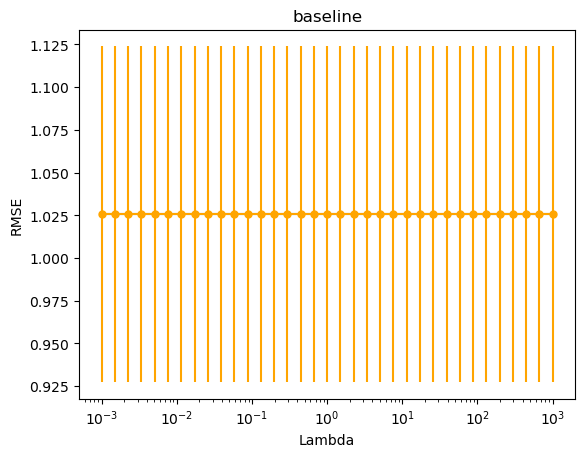

CV lambda 1 std rule for lasso is 0.13111339374215644
min val error is 0.577171297920843. This is the RMSE


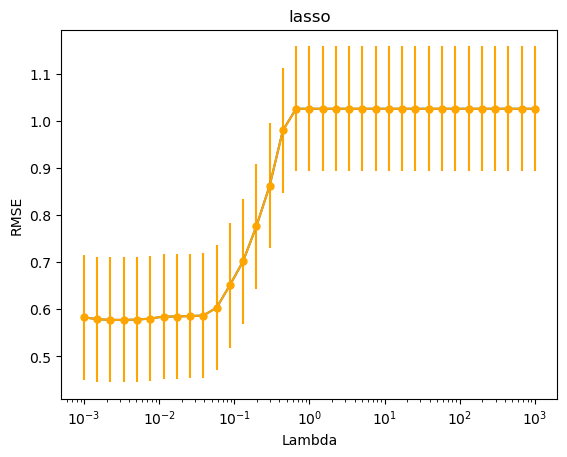

CV lambda 1 std rule for ridge is 443.66873309786155
min val error is 0.5765131610814906. This is the RMSE


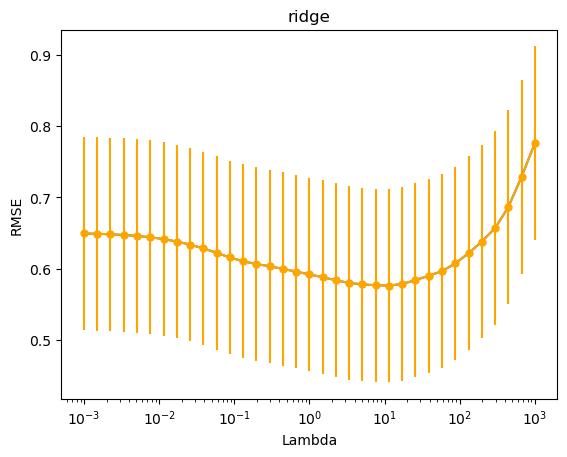

CV lambda 1 std rule for knn is 17.190722018585745
min val error is 0.6998389694041869. This is the RMSE


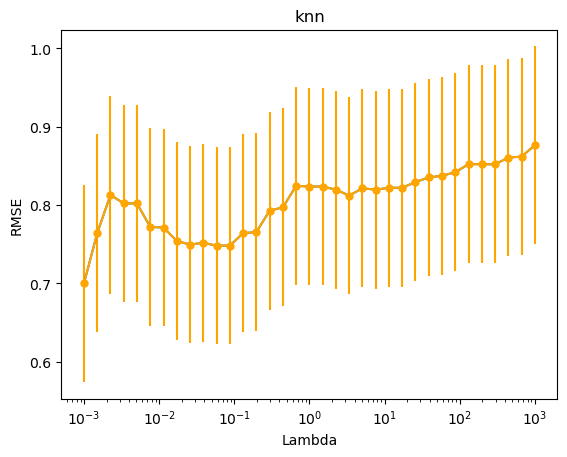

CV lambda 1 std rule for xgboost is 2.253933904734791
min val error is 0.563752862163212. This is the RMSE


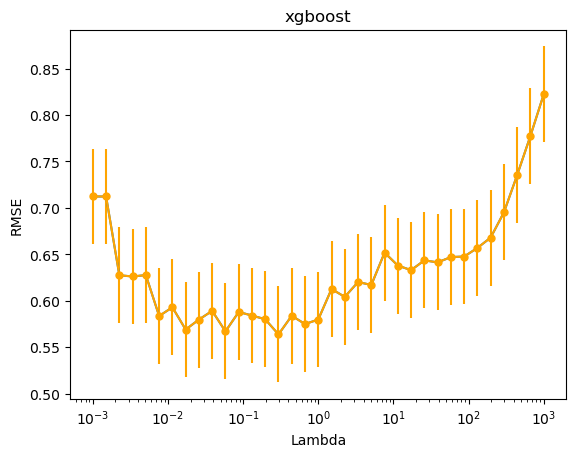

CV lambda 1 std rule for mlp is 38.74675120456136
min val error is 0.5392592262608727. This is the RMSE


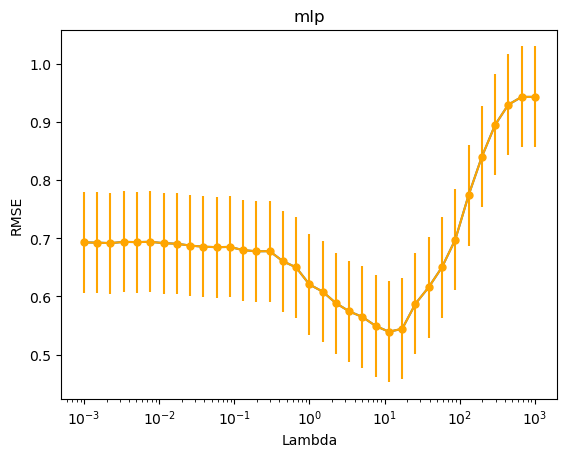

CV lambda 1 std rule for mlp_2layer is 17.190722018585745
min val error is 0.5192268597974792. This is the RMSE


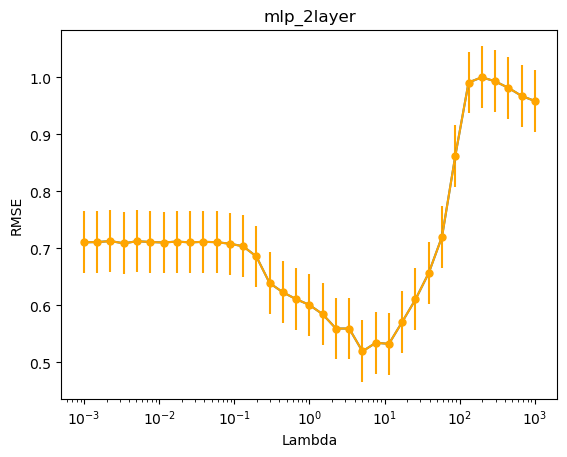

In [32]:
helper = True #helper to avoid running this overwriting previous namespace
if helper:
    regression_models = ["baseline",  "lasso", "ridge", "knn",  "xgboost", "mlp", "mlp_2layer" ]  #"mlp_2layer", "lasso","lasso-lars", "ridge", "elastic_net", "bagging-lasso", "SVR", "xgboost"
    lambdas = np.logspace(-3,3,35)
    seed = 69 
    target_column = 'active'

    data = pd.read_csv('data/HR_data_2.csv')
    CV, Xfull, Y_full_df, encoder, X_full_df, Yfull = load_data_phase_based(data)
    print("Xfull shape, YFull_single_column shape", Xfull.shape, Yfull_single_column.shape)

    Yfull_single_column = Y_full_df[target_column].values  # This will be a (n_samples,) array
    pipeline(regression_models,  Xfull, Yfull_single_column, use_CCA_embed=False, n_components=1)
    

### Supervised models using extra features

C:\Users\Bbjar\AppData\Local\Temp\ipykernel_26204\2077910625.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Round'] = data['Round'].str.lstrip('round_').astype(int)
C:\Users\Bbjar\AppData\Local\Temp\ipykernel_26204\2077910625.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Phase'] = data['Phase'].str.lstrip('phase').astype(int)


New cohort categories: ['D1_4' 'D1_6' 'D1_1' 'D1_2' 'D1_3' 'D1_5']
Dropping individual and cohort columns
Xfull shape, YFull_single_column shape (307, 161) (307,)
starting fold 0
k, Xtrain, y_train, y_test, X_test 0 (284, 161) (284,) (23,) (23, 161)
starting fold 1
k, Xtrain, y_train, y_test, X_test 1 (289, 161) (289,) (18,) (18, 161)
starting fold 2
k, Xtrain, y_train, y_test, X_test 2 (272, 161) (272,) (35,) (35, 161)
CV lambda 1 std rule for baseline is 1000.0
min val error is 1.0255127203273353. This is the RMSE


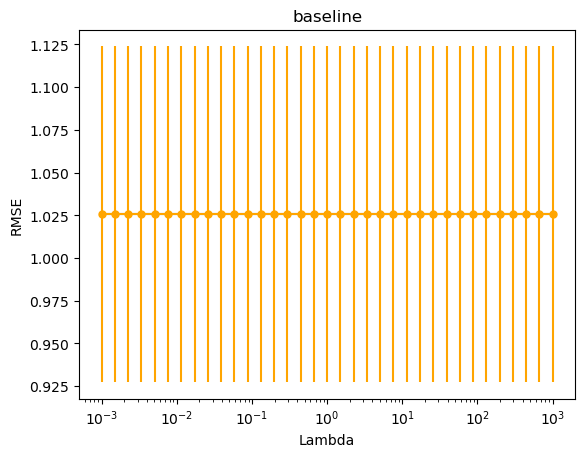

CV lambda 1 std rule for lasso is 0.13111339374215644
min val error is 0.5640661800203705. This is the RMSE


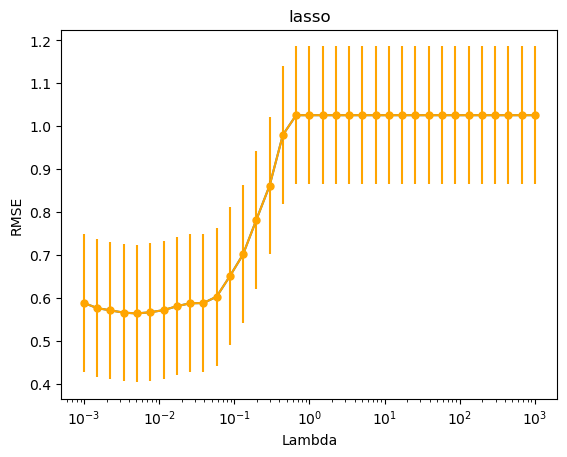

CV lambda 1 std rule for ridge is 443.66873309786155
min val error is 0.560292195449553. This is the RMSE


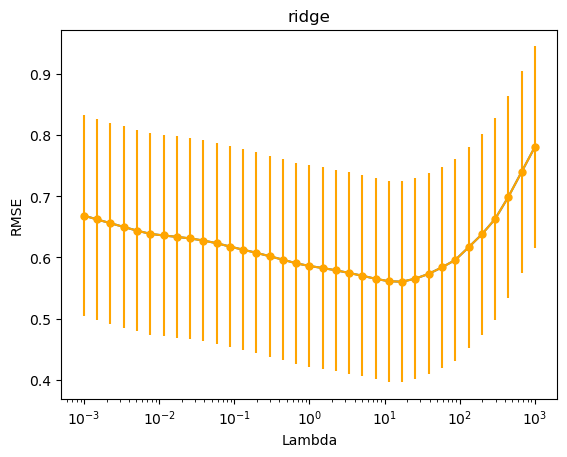

CV lambda 1 std rule for knn is 0.08733261623828438
min val error is 0.719300667126754. This is the RMSE


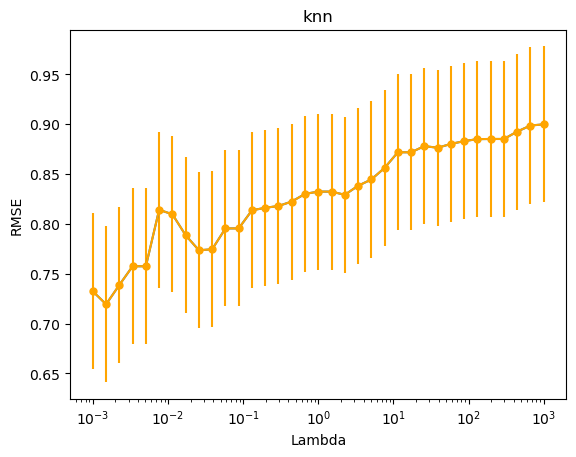

CV lambda 1 std rule for xgboost is 58.170913293743574
min val error is 0.5705390281339391. This is the RMSE


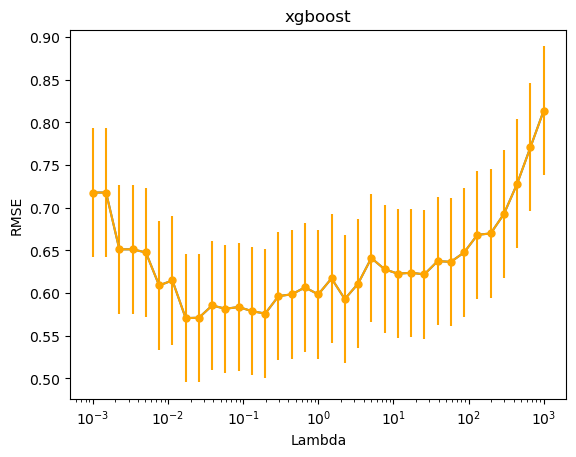

CV lambda 1 std rule for mlp is 58.170913293743574
min val error is 0.5418052350387572. This is the RMSE


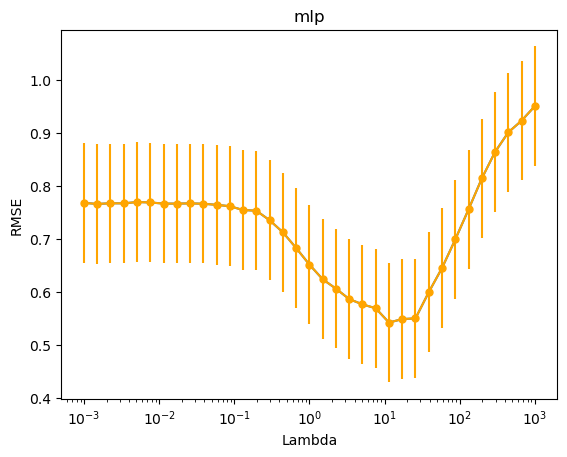

CV lambda 1 std rule for mlp_2layer is 25.808615404180767
min val error is 0.5253526593386572. This is the RMSE


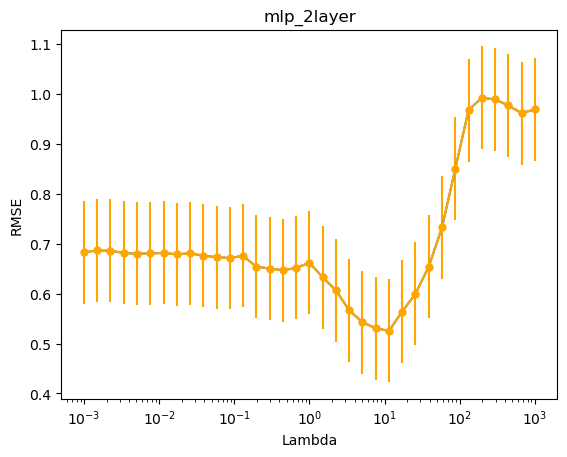

In [33]:

helper = True #helper to avoid running this overwriting previous namespace
if helper:
    data = pd.read_csv('data/HR_data_2_embeddings_all.csv')    
    data = data.drop(columns=['HR_embeddings', 'EDA_embeddings', 'BVP_embeddings', "TEMP_embeddings"])

    regression_models = ["baseline",  "lasso", "ridge", "knn",  "xgboost", "mlp", "mlp_2layer" ]
    lambdas = np.logspace(-3,3,35)
    seed = 69 
    target_column = 'active'

    CV, Xfull, Y_full_df, encoder, X_full_df, Yfull = load_data_phase_based(data)

    Yfull_single_column = Y_full_df[target_column].values  # This will be a (n_samples,) array
    print("Xfull shape, YFull_single_column shape", Xfull.shape, Yfull_single_column.shape)

    pipeline(regression_models,  Xfull, Yfull_single_column, use_CCA_embed=False, n_components=1)

C:\Users\Bbjar\AppData\Local\Temp\ipykernel_26204\2077910625.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Round'] = data['Round'].str.lstrip('round_').astype(int)
C:\Users\Bbjar\AppData\Local\Temp\ipykernel_26204\2077910625.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Phase'] = data['Phase'].str.lstrip('phase').astype(int)


New cohort categories: ['D1_4' 'D1_6' 'D1_1' 'D1_2' 'D1_3' 'D1_5']
Dropping individual and cohort columns
Xfull shape, YFull_single_column shape (308, 110) (308,)
starting fold 0
k, Xtrain, y_train, y_test, X_test 0 (285, 110) (285,) (23,) (23, 110)
starting fold 1
k, Xtrain, y_train, y_test, X_test 1 (290, 110) (290,) (18,) (18, 110)
starting fold 2
k, Xtrain, y_train, y_test, X_test 2 (272, 110) (272,) (36,) (36, 110)
CV lambda 1 std rule for baseline is 1000.0
min val error is 1.0202715850537063. This is the RMSE


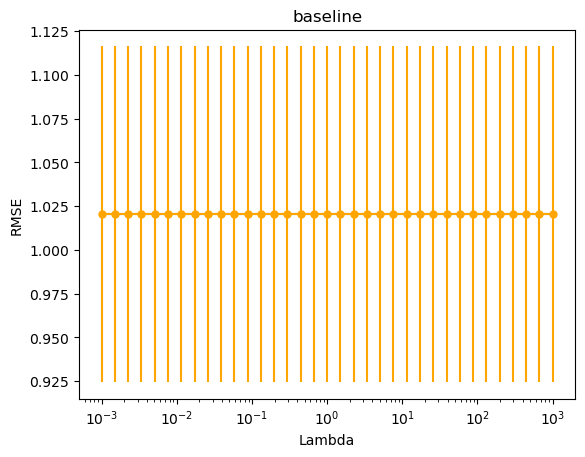

CV lambda 1 std rule for lasso is 0.13111339374215644
min val error is 0.6137890359541254. This is the RMSE


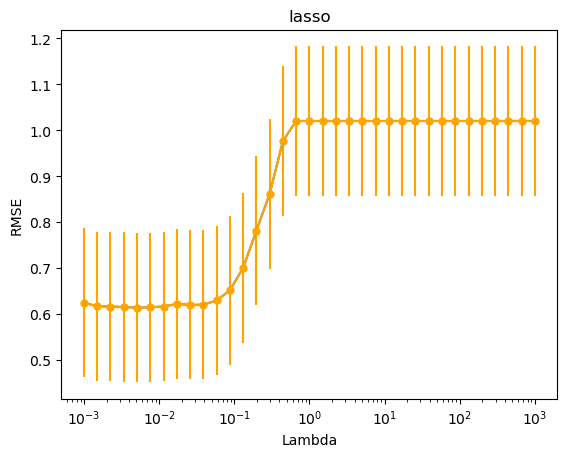

CV lambda 1 std rule for ridge is 443.66873309786155
min val error is 0.6180358606085888. This is the RMSE


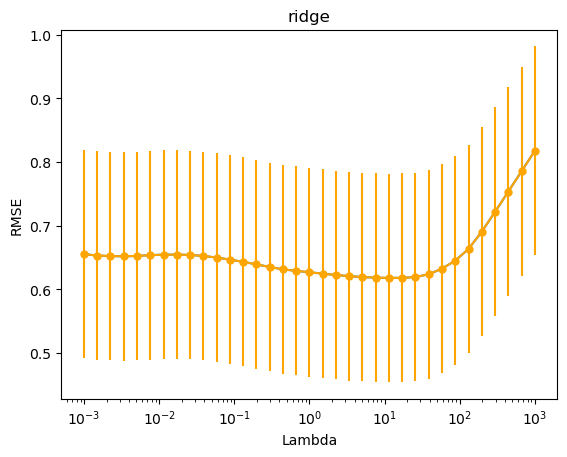

CV lambda 1 std rule for knn is 0.002253933904734791
min val error is 0.6487520128824477. This is the RMSE


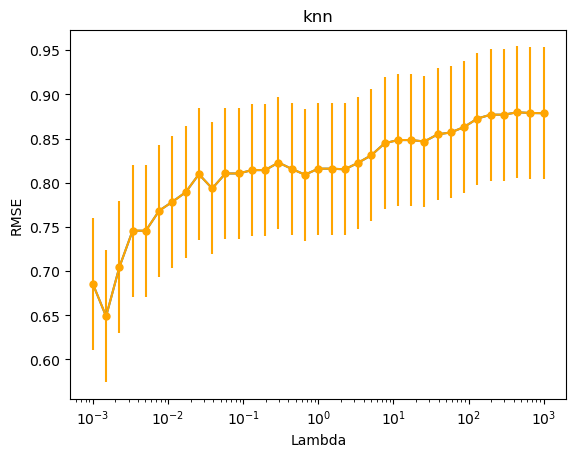

CV lambda 1 std rule for xgboost is 196.84194472866153
min val error is 0.6193681169727191. This is the RMSE


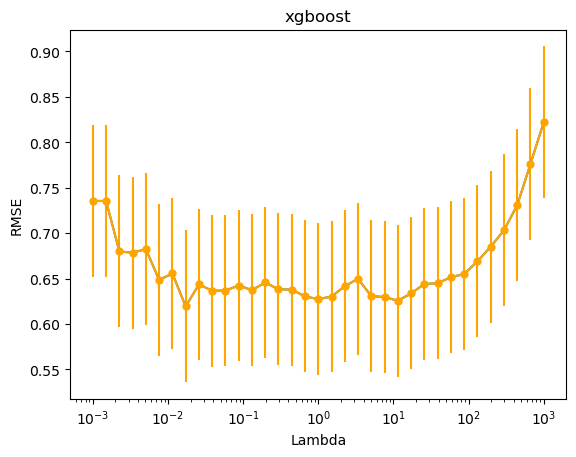

CV lambda 1 std rule for mlp is 58.170913293743574
min val error is 0.586017820120497. This is the RMSE


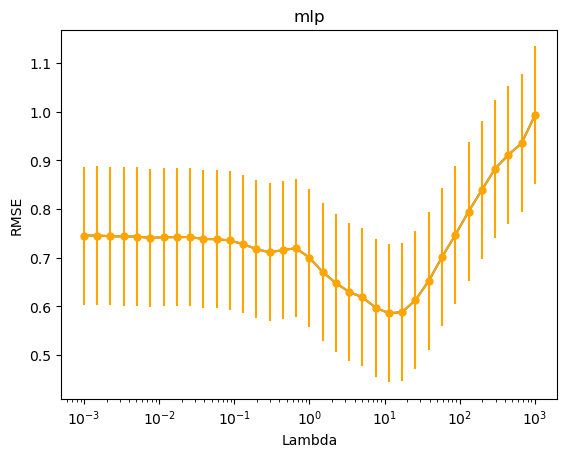

CV lambda 1 std rule for mlp_2layer is 38.74675120456136
min val error is 0.586214869395434. This is the RMSE


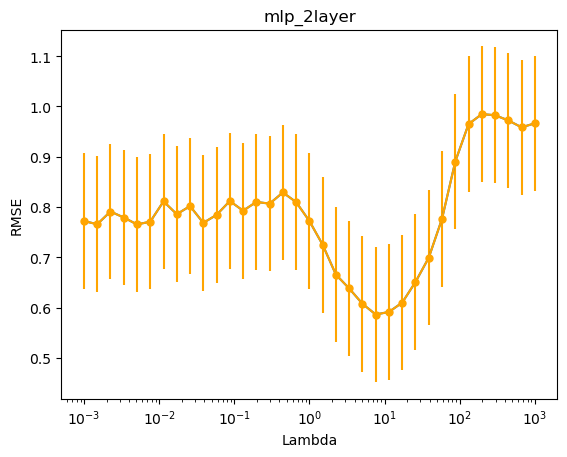

In [ ]:
helper = True #helper to avoid running this overwriting previous namespace
if helper:
    data = pd.read_csv('data/HR_data_2_embeddings_only.csv')    
    data = data.drop(columns=['HR_embeddings', 'EDA_embeddings', 'BVP_embeddings', "TEMP_embeddings"])

    regression_models = ["baseline",  "lasso", "ridge", "knn",  "xgboost", "mlp", "mlp_2layer" ]
    lambdas = np.logspace(-3,3,35)
    seed = 69 
    target_column = 'active'

    CV, Xfull, Y_full_df, encoder, X_full_df, Yfull = load_data_phase_based(data)
    
    Yfull_single_column = Y_full_df[target_column].values  # This will be a (n_samples,) array
    print("Xfull shape, YFull_single_column shape", Xfull.shape, Yfull_single_column.shape)

    pipeline(regression_models,  Xfull, Yfull_single_column, use_CCA_embed=False, n_components=1)